In [1]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

setup geometry

In [2]:
geo = SplineGeometry()
geo.AddRectangle( (-3,-2), (3, 2), bcs = ("top", "out", "bot", "in"), leftdomain=1, rightdomain=0)#, maxh=0.4)
#geo.AddCircle(c=(0, 0), r=1, leftdomain=2, rightdomain=1, bc="outer_cylinder", maxh=0.1)
geo.AddCircle(c=(0, 0), r=0.5, leftdomain=0, rightdomain=1, bc="cyl")#, maxh=0.04)
geo.SetDomainMaxH(2, 0.08)
mesh = Mesh(geo.GenerateMesh(maxh=0.25))
mesh.Curve(5);

geo_1 = SplineGeometry()
geo_1.AddRectangle((0,0),(1,1))
mesh_1 = Mesh(geo_1.GenerateMesh())
Draw(mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': None…

BaseWebGuiScene

setup FEM space

In [3]:
# Order of spaces
k = 2
# H1 vs VectorH1 -> vector field?!
V = VectorH1(mesh,order=k, dirichlet="top|bot|cyl|in|out")
Q = H1(mesh,order=k-1)
FES = FESpace([V,Q]) # [V,Q] (without VectorH1)

setup bilinear form
velocityfield u and pressurefield p

In [4]:
u,p = FES.TrialFunction()
v,q = FES.TestFunction()

a = BilinearForm(FES)
a += (InnerProduct(grad(u),grad(v))+div(u)*q+div(v)*p).Compile()*dx
a.Assemble()

setup boundary conditions

In [5]:
gfu = GridFunction(FES)
uinf = 0.001
uin = CoefficientFunction((uinf,0))
gfu.components[0].Set(uin, definedon=mesh.Boundaries("in|top|bot|out"))

x_velocity = CoefficientFunction(gfu.components[0])
scene_state = Draw(x_velocity, mesh, "vel")

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

solve stokes

In [6]:
def solveStokes():
    res = gfu.vec.CreateVector()
    res.data = -a.mat * gfu.vec
    inv = a.mat.Inverse(FES.FreeDofs())
    gfu.vec.data += inv * res
    scene_state.Redraw()
solveStokes()

# Calculations/Setup for all the side constraints

Drag/ "dissipated energy" [should be working]

$J(\Omega ) = \frac{1}{2} \int_\Omega Du : Du dx$ 

In [7]:
def calc_drag(gfu):
    u = gfu.components[0]
    return 0.5*(InnerProduct(u,u)).Compile()*dx

### get surface area of mesh (main issue)
$vol(\Omega) = \int_{\Omega} 1 \,dx \in \mathbb{R}$ should stay constant <br>
entire area: $A = 6*4=24$ <br>
$\alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2$

In [8]:
alpha = 1e-4
surf_t = CoefficientFunction(1)
surf_0 = Integrate(surf_t,mesh)

def calc_surf_change():
    return alpha*(surf_t*dx-surf_0)**2

### barycenter (not necessarily useful yet)
$bc^\Omega = \frac{1}{vol(\Omega)}\int_{\Omega}x\,dx \in \mathbb{R}^d$ for each dimension!!

In [9]:
bc_tx = CoefficientFunction(x)
bc_ty = CoefficientFunction(y)
bc_0x = 1/surf_0*Integrate(bc_tx,mesh)
bc_0y = 1/surf_0*Integrate(bc_ty,mesh)

In [10]:
def Cost(gfu):
    return calc_drag(gfu) + calc_surf_change()# + calc_bc_change()

# creation of Shapediff Space + pertubation Function
function that will perturb our mesh

In [11]:
# Test and trial functions for shape derivate -> do we even need this?
VEC = H1(mesh, order=2, dim=2, dirichlet="top|bot|in|out")
PHI, X = VEC.TnT()
# gfset denotes the deformation of the original domain and will be updated during the shape optimization
gfset = GridFunction(VEC)
gfset.Set((0,0))
mesh.SetDeformation(gfset)
SetVisualization (deformation=True)

# deformation calculation
gfX = GridFunction(VEC)

In [12]:
# try for already transformed cost function:
n = specialcf.normal(2)
def TransfCost():
    #return div(X)**2*dx
    return (gfX*n)**2*ds(definedon="cyl")

# Shape Optimization
$\min_{h,u,s} \int_{\Omega(s)} \sum_{i,j=1}^2 \left( \frac{\partial u_i}{\partial x_j}\right)^2~\mathrm{d} x
 + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s))-\mathrm{Bc}_j(\Omega_0)\Big)^2,$

$\frac{1}{2} \int_\Omega Du : Du dx + \alpha\Big(\mathrm{Vol}(\Omega(s))-\mathrm{Vol}(\Omega_0)\Big)^2
+ \beta\sum_{j=1}^2 \Big(\mathrm{Bc}_j(\Omega(s)) - \mathrm{Bc}_j(\Omega_0)\Big)^2,$ (1)

# Manual implementation of Shape Derivative

$dJ(\Omega )(X) = \int_\Omega S1 : DX dx$

$S1 =
\biggl( \frac{1}{2} Du : Du - p div(u) \biggr) I_2 + Du^\top p - Du^\top Du$

## Lieber Kevin, Hier darunter sind die ersten Versuche für die manuelle definition der Shape Derrivative. In der zweitletzten Cell ist auch noch eine Frage betreffend gfXnorm.
## Fällt dir Hier grad was auf was wir falsch machen?

## Liebe Grüsse Paul & Camilo

In [21]:
dJOmega = LinearForm(VEC)

# J Shape Derivative by hand
u = gfu.components[0]
p = gfu.components[1]
S1 = (0.5*InnerProduct(grad(u),grad(u))-p*div(u))*Id(2) + grad(u).trans*p-grad(u).trans*grad(u)
dJOmega += InnerProduct(S1,grad(X)).Compile()*dx

# Equation Derivative (doesn't work on H1)
#ux = u.MDComponent(0)
#uy = u.MDComponent(1)
#div_u = grad(ux)[0]+grad(uy)[1] # custom div
#dJOmega += ((grad(ux)*grad(ux)+grad(uy)*grad(uy) + div(u)*p + div(u)*p).Compile() * dx).DiffShape(X)

#dJOmega += ((InnerProduct(grad(u),grad(v))+div(u)*q+div(v)*p).Compile()*dx).DiffShape(X)

# volume side constraint
vol = Parameter(1)
vol.Set(Integrate(surf_t,mesh))
alpha0 = 1e-4
alpha = Parameter(alpha0)
dJOmega += (alpha*((vol-surf_0)**2)*dx).DiffShape(X) # (definedon="mesh_1")

# barycenter x sideconstraint
beta0 = 1e-3
beta = Parameter(beta0)
bc_x = Parameter(1)
bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
#dJOmega += (beta*((bc_x-bc_0x)**2)*dx).DiffShape(X)

# barycenter y sideconstraint
bc_y = Parameter(1)
bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
#dJOmega += (beta*((bc_y-bc_0y)**2)*dx).DiffShape(X)

b = BilinearForm(VEC)
b += InnerProduct(grad(X),grad(PHI)).Compile()*dx + InnerProduct(X,PHI).Compile()*dx # H1 InnerProduct

In [22]:
def updateParams(v=False):
    vol.Set(Integrate(surf_t,mesh))
    bc_x.Set((1/surf_0)*Integrate(bc_tx,mesh))
    bc_y.Set((1/surf_0)*Integrate(bc_ty,mesh))
    if(v):
        print(vol.Get(), bc_x.Get(), bc_y.Get())
updateParams()

def increaseParams(k=2,v=False):
    alpha.Set(alpha.Get()*k)
    beta.Set(beta.Get()*k)
    if(v):
        print("alpha: ", alpha.Get(), ", beta: ", beta.Get())

In [23]:
def SolveDeformationEquation():
    rhs = gfX.vec.CreateVector()
    rhs.data = dJOmega.vec - b.mat * gfX.vec
    update = gfX.vec.CreateVector()
    update.data = b.mat.Inverse(VEC.FreeDofs()) * rhs
    gfX.vec.data += update

## Iterations done properly

In [24]:
scene = Draw(gfset)

WebGuiWidget(value={'ngsolve_version': '6.2.2201', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': Fals…

In [28]:
gfset.Set((0,0))
mesh.SetDeformation(gfset)
scene.Redraw()

updateParams()
alpha0 = 1e-4
beta0 = 1e-4
alpha.Set(alpha0)
beta.Set(beta0)

a.Assemble()
solveStokes()

data = [[] for x in range(6)]

iter_max = 500
Jold = Integrate(calc_drag(gfu), mesh)

# try parts of loop
mesh.SetDeformation(gfset)
scene.Redraw()

# input("Press enter to start optimization")
for i in range(0,iter_max):
    mesh.SetDeformation(gfset)
    scene.Redraw()
    scene_state.Redraw()
    
    if i%50 == 0:
        print('drag at iteration', i, ': ', Jold)
        
    titles = ["drag","volume","bc_x","bc_y","scale","gfxnorm"] # collecting data
    data[0].append(Integrate(calc_drag(gfu),mesh))
    data[1].append(vol.Get())
    data[2].append(bc_x.Get())
    data[3].append(bc_y.Get())
    
    a.Assemble()
    solveStokes()
    
    b.Assemble()
    dJOmega.Assemble()
    SolveDeformationEquation()
    updateParams()
    
    Jnew = Integrate(calc_drag(gfu), mesh)
    mesh.UnsetDeformation()
    
    # Frage K. Sturm: wie können wir die Veränderung nur an der boundary messen? (Der Zylinder)
    gfxnorm = Norm(gfX.vec)
    
    scale = 0.1 / Norm(gfX.vec)
    #scale = 0.01 / gfxnorm
    data[4].append(scale)
    jdiff = abs(Jnew-Jold)
    data[5].append(gfxnorm)
    
    if(gfxnorm < 1e-5):
        if alpha.Get() < 1:
            increaseParams(1.5,True)
        else:
            print("alpha too big")
            break
            
    gfsetOld = gfset
    gfset.vec.data -= scale * gfX.vec
    Jold = Jnew

    Redraw(blocking=True)

drag at iteration 0 :  1.3624189735703593e-05
drag at iteration 50 :  1.35750369280603e-05
drag at iteration 100 :  1.356706857984597e-05
drag at iteration 150 :  1.3556154882348832e-05
drag at iteration 200 :  1.3532775967355865e-05
drag at iteration 250 :  1.351325790881027e-05
drag at iteration 300 :  1.3469811676886948e-05
drag at iteration 350 :  1.3360060893721413e-05
drag at iteration 400 :  1.320993903319316e-05
drag at iteration 450 :  1.3286096932567844e-05


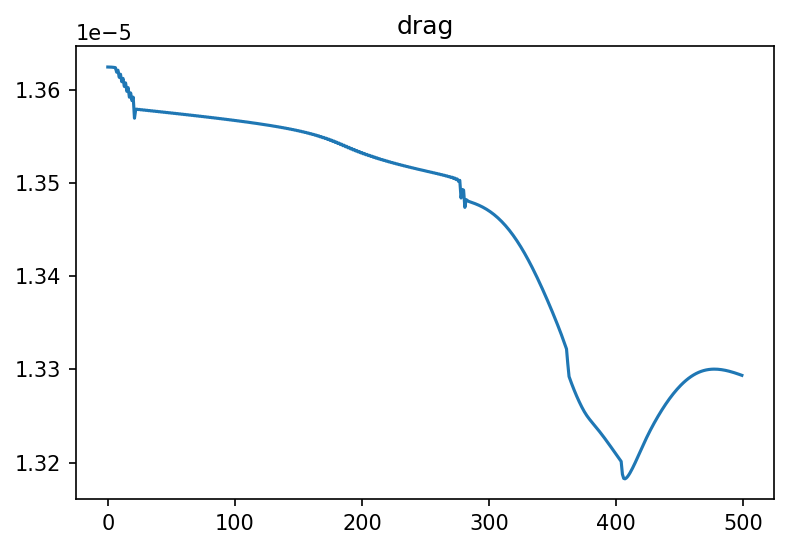

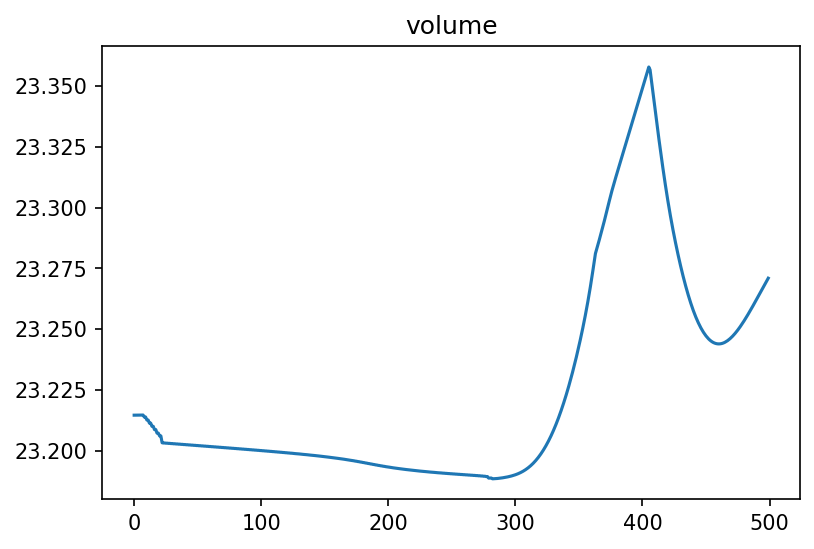

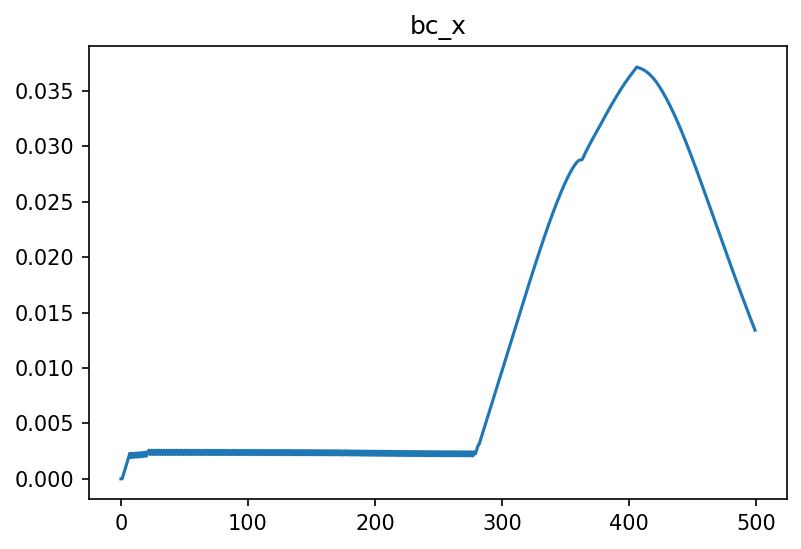

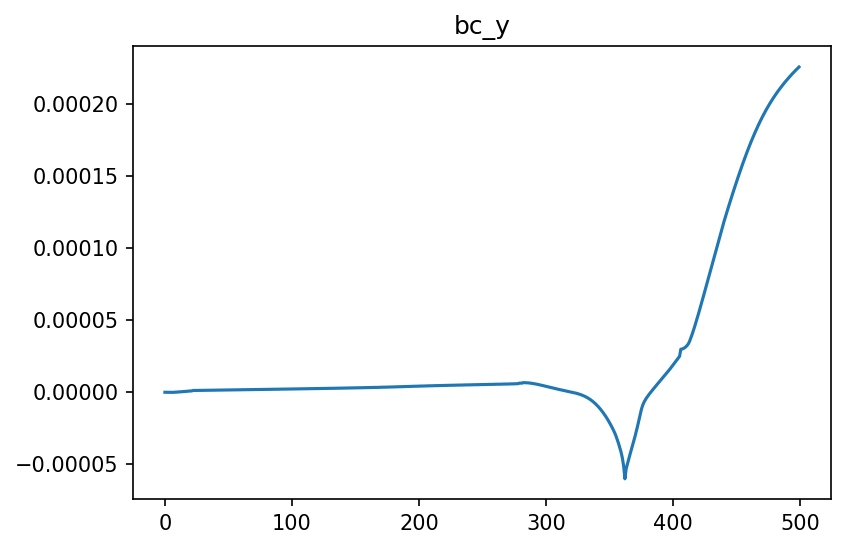

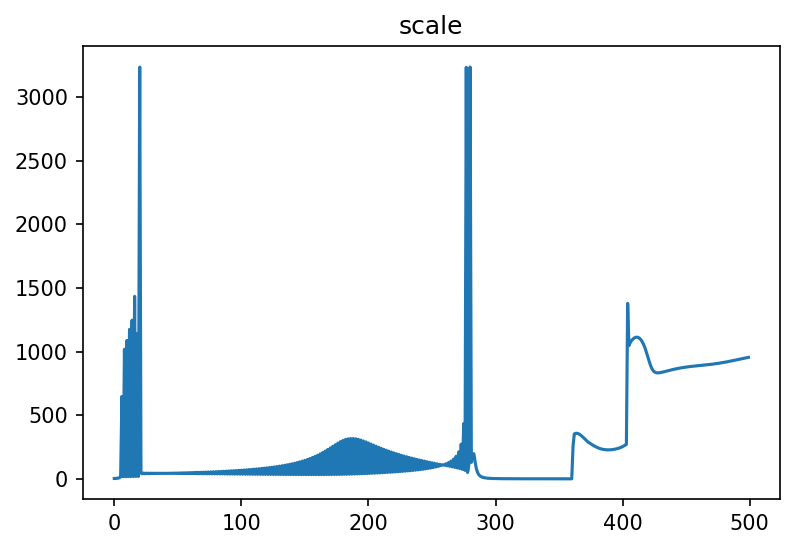

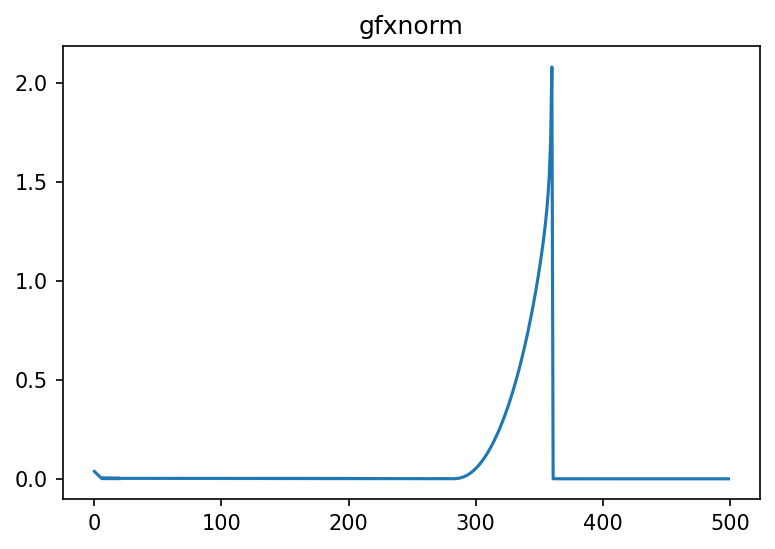

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
c = 0
for e in data:
    plt.figure(c)
    plt.title(titles[c])
    plt.plot(range(len(e)),e)
    c += 1